# Clustering sur CAMille

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
import nltk
import collections
import os
import string
import sys
from pprint import pprint
from scipy.spatial.distance import cosine
from nltk import word_tokenize

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from wordcloud import WordCloud

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ing Armel
[nltk_data]     Fopa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Choix de la décennie et exploration du fichiers CAMille

Verification du dossiers CAMille

In [3]:
data_dir = Path("../../data/txt")

print("Dossier existant?", data_dir.exists())

Dossier existant? True


Recencons les fichiers par decennie


In [ ]:
from collections import defaultdict


data_dir = Path("../../data/txt")
all_txt = sorted(data_dir.glob("*.txt"))

# Dictionnaire décennie : liste de fichiers
decades = defaultdict(list)

pattern = re.compile(r"(\d{4})")

for path in all_txt:
    match = pattern.search(path.name)
    if match:
        year = int(match.group(1))
        decade = (year // 10) * 10
        decades[decade].append(path.name)

# Afficher un résumé clair
print("Nombre de fichiers par décennie :\n")
for dec in sorted(decades.keys()):
    print(f"{dec}s : {len(decades[dec])} fichiers")
    for name in decades[dec]:
        print("   -", name)
    print()


📊 Nombre de fichiers par décennie :

1830s : 1 fichiers
   - KB_JB555_1836-02-08_01-00002.txt

1840s : 1 fichiers
   - KB_JB449_1846-05-30_01-00002.txt

1850s : 3 fichiers
   - KB_JB494_1853-10-30_01-0002.txt
   - KB_JB567_1857-02-02_01-00003.txt
   - KB_JB572_1850-03-15_01-00003.txt

1860s : 2 fichiers
   - KB_JB638_1860-05-21_01-00002.txt
   - KB_JB92_1860-02-09_01-00003.txt

1870s : 1 fichiers
   - KB_JB92_1873-02-06_01-00002.txt

1880s : 4 fichiers
   - KB_JB258_1884-09-03_01-0003.txt
   - KB_JB837_1886-12-28_01-00002.txt
   - KB_JB838_1887-12-28_01-00003.txt
   - KB_JB92_1885-09-29_01-00002.txt

1890s : 7 fichiers
   - KB_JB230_1892-08-07_01-0003.txt
   - KB_JB258_1894-12-09_01-0003.txt
   - KB_JB421_1899-05-15_01-00003.txt
   - KB_JB555_1899-01-19_01-00003.txt
   - KB_JB567_1892-01-03_01-00005.txt
   - KB_JB685_1894-05-14_01-0003.txt
   - KB_JB729_1895-10-08_01-00003.txt

1900s : 4 fichiers
   - KB_JB230_1903-10-16_01-0002.txt
   - KB_JB258_1906-01-09_01-0002.txt
   - KB_JB638_19

Choix de la décennie

In [47]:
DECADE = 1920
files_decade = decades[DECADE]

print(f"Decennie sélectionné : {DECADE}s")
print(f"Nombre de fichiers : {len(files_decade)}")

for name in files_decade:
    print(" -", name)

Decennie sélectionné : 1920s
Nombre de fichiers : 7
 - KB_JB421_1926-10-29_01-00002.txt
 - KB_JB427_1920-01-10_01-00004.txt
 - KB_JB494_1922-09-28_01-0005.txt
 - KB_JB567_1924-08-30_01-00003.txt
 - KB_JB572_1927-07-20_01-00005.txt
 - KB_JB729_1927-11-15_01-00004.txt
 - KB_JB837_1925-01-01_01-00003.txt


Lecture du contenu des fichiers textes

In [48]:
# on va proceder à la lecture du contenu de chaque fichier dans une liste
docs = []
fnames = []

for path_name in files_decade:
    path = data_dir / path_name

 # Essai de lecture avec différents encodages
    for enc in("utf-8", "latin-1", "cp1252"):
        try:
            with open(path, "r", encoding=enc, errors="ignore") as f:
                text = f.read()
            docs.append(text)
            fnames.append(path_name)
            break
        except Exception as e:
            print(f"Erreur avec {enc} pour {path_name}: {e}")
        
print(f"\nNombre de documents chargés : {len(docs)}")
for i, name in enumerate(fnames):
    print(f"{i}: {name}")



Nombre de documents chargés : 7
0: KB_JB421_1926-10-29_01-00002.txt
1: KB_JB427_1920-01-10_01-00004.txt
2: KB_JB494_1922-09-28_01-0005.txt
3: KB_JB567_1924-08-30_01-00003.txt
4: KB_JB572_1927-07-20_01-00005.txt
5: KB_JB729_1927-11-15_01-00004.txt
6: KB_JB837_1925-01-01_01-00003.txt


Vectorisation TF-IDF

Stopwords

In [52]:
#Liste des mots vides
sw = stopwords.words("french")
sw += ["les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout",
       "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous",
       "celle", "entre", "encore", "toutes", "pendant", "moins", "dire", "cela", "non",
       "faut", "trois", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres",
       "van", "het", "autre", "jusqu", "ville", "rossel", "dem"]
sw = list(set(sw))

Vectorisation TF-IDF

In [53]:
# Initialisation du vecteur TF-IDF

vectorizer = TfidfVectorizer(stop_words=sw, lowercase=True, max_df=0.8, min_df=2)

#Transformation des documents en matrice TF-IDF

X = vectorizer.fit_transform(docs)

print("Dimensions de la matrice TF-IDF:", X.shape)

Dimensions de la matrice TF-IDF: (7, 2747)


Definition et application du KMeans

In [54]:
# on pourra tester 2,3,4 .... de clusters

N_CLUSTERS = 3

kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=0,
    n_init=10
)

kmeans.fit(X)

labels = kmeans.labels_

print("Labels de cluster pour chaque document:", labels)

Labels de cluster pour chaque document: [2 2 1 0 0 0 2]


Association fichier-cluster

In [56]:
df_clusters = pd.DataFrame({
    "fichier": fnames,
    "cluster": labels
})

print(df_clusters)

print("\nReparation par cluster:")
print(df_clusters.groupby("cluster")["fichier"].count())

                            fichier  cluster
0  KB_JB421_1926-10-29_01-00002.txt        2
1  KB_JB427_1920-01-10_01-00004.txt        2
2   KB_JB494_1922-09-28_01-0005.txt        1
3  KB_JB567_1924-08-30_01-00003.txt        0
4  KB_JB572_1927-07-20_01-00005.txt        0
5  KB_JB729_1927-11-15_01-00004.txt        0
6  KB_JB837_1925-01-01_01-00003.txt        2

Reparation par cluster:
cluster
0    3
1    1
2    3
Name: fichier, dtype: int64


Mots caracteristiques par cluster

In [59]:
#Recuperons les noms de colonnes (les mots)

terms = np.array(vectorizer.get_feature_names_out())

#Calculons les centres des clusters

centroids = kmeans.cluster_centers_

#Affichons les 10 mots les plus representatifs par cluster

for i in range(N_CLUSTERS):
    top_terms = terms[centroids[i].argsort()[-10:][::-1]]
    print(f"\nCluster {i} - mots caracteristiques :")
    print(", ".join(top_terms))


Cluster 0 - mots caracteristiques :
75, al, congo, br, ei, 00, ind, prix, 60, 59

Cluster 1 - mots caracteristiques :
ml, 4m, um, mt, tm, ut, mm, id, lt, té

Cluster 2 - mots caracteristiques :
rue, film, général, journal, 000, bur, demande, prix, ouvriers, où


Nettoyage leger du texte pour l'elimination du bruit OCR

In [60]:
def clean_text(text):

    #on supprime les chiffres et caracteres speciaux
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', ' ', text)

    #on supprime les mots trop courts
    text = ' '.join([w for w in text.split() if len(w)>2])
    return text.lower()

docs_clean = [clean_text(t) for t in docs] # version nettoyée du corpus

print(f"Nombre de documents nettoyés : {len(docs_clean)}")
print("\nExtrait d'un texte nettoyé : \n")
print(docs_clean[0][:500])


Nombre de documents nettoyés : 7

Extrait d'un texte nettoyé : 

mariage prince léopold départ famille royale famille royale rendant stockholm pour assister mariage prince léopold princesse princesse astrid âge huit ans astrid quittera bruxelles samedi scir roi reine prince charles princesse marie josé accompa gnés comte jean mérode grand maréchal cour cointe caraman imay dame honneur des majors hennin boussu walcourt raquez officiers ordonnance prendront place dans une berline royale qui sera attachée milieu train quittant gare nord qui fera excep tionnellem


Nouveau TF-IDF + nouveau KMeans

In [61]:
# On recree la matrice TF-IDF pour nos textes nettoyes

x_clean = vectorizer.fit_transform(docs_clean)

#Nouveau modele KMeans

kmeans_clean = KMeans(
    n_clusters = N_CLUSTERS,
    random_state = 0,
    n_init= 10
)
kmeans_clean.fit(x_clean)

labels_clean = kmeans_clean.labels_
print("labels de cluster apres nettoyage:", labels_clean)

labels de cluster apres nettoyage: [1 1 2 0 0 2 1]


Mots caracteristiques apres nettoyage

In [62]:
terms_clean = np.array(vectorizer.get_feature_names_out())
centroids_clean = kmeans_clean.cluster_centers_

for i in range(N_CLUSTERS):
    top_idx = centroids_clean[i].argsort()[-10:][::-1]
    top_terms = terms_clean[top_idx]
    print(f"\nCluster {i} (nettoyé) : mots caractéristiques :")
    print(", ".join(top_terms))


Cluster 0 (nettoyé) : mots caractéristiques :
prix, congo, juillet, club, belg, fil, ind, contrôle, long, tis

Cluster 1 (nettoyé) : mots caractéristiques :
rue, film, journal, général, bur, demande, prix, ouvriers, janvier, cour

Cluster 2 (nettoyé) : mots caractéristiques :
ord, lit, cap, div, mil, ill, iii, iti, admis, capital


Aperçu de la matrice de vecteurs TF-IDF

In [71]:
# Conversion de la matrice TF-IDF en DataFrame pour visualisation
df_vectors = pd.DataFrame(
    x_clean.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Ajout du nom du fichier pour chaque ligne
df_vectors.insert(0, "fichier", fnames)

# Afficher les 7 premières lignes
pd.set_option("display.max_columns", 15) 
print("Aperçu de la matrice de vecteurs TF-IDF :")
df_vectors.head()

Aperçu de la matrice de vecteurs TF-IDF :


,fichier,abandon,abattoir,abbé,abonnement,accident,accord,...,étr,étranger,étude,évident,événement,îes,île
0,KB_JB421_1926-10-29_01-00002.txt,0.000000,0.000000,0.015850,0.000000,0.000000,0.027096,...,0.000000,0.031700,0.000000,0.031700,0.031700,0.000000,0.000000
1,KB_JB427_1920-01-10_01-00004.txt,0.000000,0.016807,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016807,0.000000,0.016807,0.000000,0.016807
2,KB_JB494_1922-09-28_01-0005.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,KB_JB567_1924-08-30_01-00003.txt,0.016683,0.000000,0.000000,0.016683,0.000000,0.014260,...,0.000000,0.016683,0.000000,0.000000,0.000000,0.016683,0.016683
4,KB_JB572_1927-07-20_01-00005.txt,0.000000,0.018575,0.018575,0.000000,0.074301,0.000000,...,0.018575,0.000000,0.000000,0.018575,0.000000,0.000000,0.000000


## Visualisation PCA

Réduction de dimension (PCA)

In [67]:
# On reduit à deux dimensions pour visualisation

pca = PCA(n_components=2, random_state=0)
x_pca = pca.fit_transform(x_clean.toarray())

print("Dimensions reduites:", x_pca.shape)

Dimensions reduites: (7, 2)


Visualisation des clusters en 2D

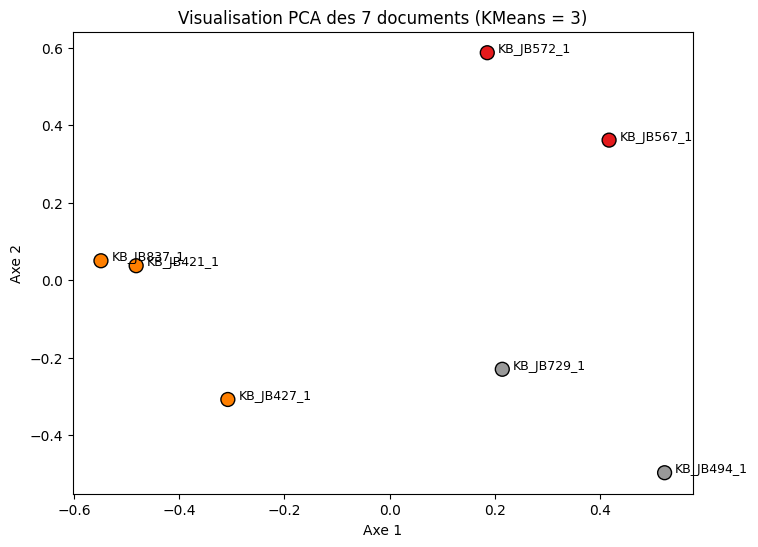

In [70]:
plt.figure(figsize=(8,6))
plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=labels_clean,
    cmap='Set1',
    s=100,
    edgecolor='k'
)

for i, name in enumerate(fnames):
    plt.text(x_pca[i, 0]+0.02, x_pca[i, 1], name[:10], fontsize=9)

plt.title(f"Visualisation PCA des {len(docs_clean)} documents (KMeans = {N_CLUSTERS})")
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.show()

Amelioration du graphique

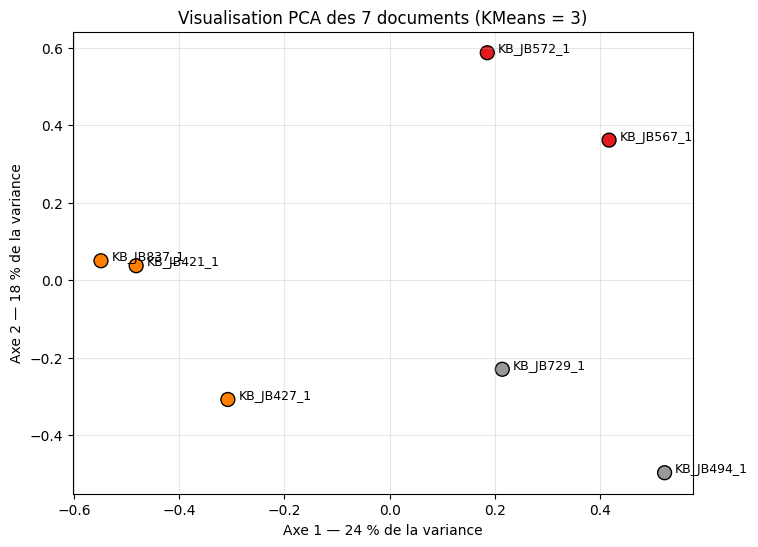

In [75]:
# Réduction à 2 dimensions
pca = PCA(n_components=2, random_state=0)
x_pca = pca.fit_transform(x_clean.toarray())

# Tracé des clusters
plt.figure(figsize=(8,6))
plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=labels_clean,
    cmap='Set1',
    s=100,
    edgecolor='k'
)

for i, name in enumerate(fnames):
    plt.text(x_pca[i, 0]+0.02, x_pca[i, 1], name[:10], fontsize=9)

plt.title(f"Visualisation PCA des {len(docs_clean)} documents (KMeans = {N_CLUSTERS})", fontsize=12)
plt.xlabel(f"Axe 1 — {pca.explained_variance_ratio_[0]*100:.0f} % de la variance")
plt.ylabel(f"Axe 2 — {pca.explained_variance_ratio_[1]*100:.0f} % de la variance")
plt.grid(alpha=0.3)
plt.show()
